In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_ZIP = '/content/drive/MyDrive/final.zip' # compress the github repo and put it here
WORKDIR   = '/content/545final_ws/'
local_zip = f'{WORKDIR}/final.zip'

In [ ]:
import os, shutil, subprocess, pathlib


os.makedirs(WORKDIR, exist_ok=True)
if not os.path.exists(local_zip):
    subprocess.run(['cp', '-n', DRIVE_ZIP, local_zip], check=True)
    subprocess.run(['unzip', '-q', local_zip, '-d', WORKDIR], check=True)

In [ ]:
import torch
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


/tmp/ipython-input-1509702984.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
# Basic configuration toggles
MODEL_NAME = "ViT-B-32"
PRETRAINED_DATASET = "laion2b_s34b_b79k"
DEVICE_PREFERENCE = "cuda"  # change to "cuda" or "cpu" if needed
SEED = 42

RUN_SPLITS = ["train", "test"]  # adjust to limit splits
LIMIT_IMAGES = None  # lower for quick smoke tests
BATCH_SIZE = 48
K_VALUES = (1, 5, 10)

TEXT_CHUNK_WORDS = 8  # set 0 to disable chunking
TEXT_CHUNK_STRIDE = 4
TEXT_POOLING = "attn"  # mean / max / attn
TEXT_CHUNK_THRESHOLD = 15 # captions shorter than this keep original form unless entities are used

ADAPTER_STEPS = 500
ADAPTER_LR = 1e-5
ADAPTER_LOGIT_LR = 5e-7
ADAPTER_BATCH = 48
ADAPTER_HIDDEN = 64
DISTILL_WEIGHTS = [0.2, 0.75]
ENTITY_PHRASE_MIN_WORDS = 2
FINE_GRAINED_WEIGHT = 0.5

CACHE_CHUNK_IMAGE_EMBEDS = True
TEACHER_CAPTION_CACHE_ON_CPU = False


In [ ]:
import math
import os
import random
import sys
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

In [ ]:
import sys
from pathlib import Path

entities_python_root = Path('545final_ws/final').resolve()
if str(entities_python_root) not in sys.path:
    sys.path.insert(0, str(entities_python_root))

from adapter import attach_text_adapters, detach_text_adapters, normalize_features
from utils import (
    encode_openclip_embeddings,
    ensure_dir,
    load_flickr30k_karpathy_json,
    pool_chunk_embeddings,
    chunk_caption_words,
    recall_at_k_image_to_text,
    recall_at_k_text_to_image,
    select_torch_device,
    set_all_seeds,
)

In [ ]:
root = Path(WORKDIR+'/final').resolve()
output_dir = root / "output"
ensure_dir(output_dir)
plot_dir = output_dir / "tmp"

ENTITIES_ROOT = root / "data/flickr30k/flickr30k_entities-master"
IMAGES_ROOT = root / "data/flickr30k/flickr30k-images"


ensure_dir(plot_dir)
device = select_torch_device(DEVICE_PREFERENCE)
set_all_seeds(SEED)


print(f"root: {root}")
print(f"output_dir: {output_dir}")
print(f"device: {device}")

root: /content/545final_ws/final
output_dir: /content/545final_ws/final/output
device: cuda


In [ ]:
!ls /content/545final_ws/final/output

flickr30k_annotations_test.json   flickr30k_annotations_val.json
flickr30k_annotations_train.json  tmp


In [ ]:
!pip -q install torch torchvision
!pip -q install open_clip_torch pillow numpy pandas regex tqdm


In [ ]:
# Load CLIP model and tokenizer
import open_clip  # type: ignore

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAINED_DATASET,
    device=device,
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model.eval()

visual_module = cast(torch.nn.Module, model.visual)
for p in visual_module.parameters():
    p.requires_grad_(False)

image_transform = cast(Callable[[Image.Image], torch.Tensor], preprocess)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"model ready, trainable params: {trainable_params:,}")

model ready, trainable params: 63,428,097


In [ ]:
def load_split(split: str) -> List[Dict[str, object]]:
    ann_path = output_dir / f"flickr30k_annotations_{split}.json"
    return load_flickr30k_karpathy_json(
        annotations_path=ann_path,
        images_root=Path(IMAGES_ROOT),
        split=split,
        limit=LIMIT_IMAGES,
    )

datasets: Dict[str, List[Dict[str, object]]] = {}
for split in RUN_SPLITS:
    split_data = load_split(split)
    datasets[split] = split_data
    num_caps = sum(len(cast(List[str], item["captions"])) for item in split_data)
    print(f"split={split} images={len(split_data)} captions={num_caps}")


split=train images=29783 captions=148915
split=test images=1000 captions=5000


In [ ]:
def build_entity_phrase_cache(dataset: List[Dict[str, object]]) -> Dict[str, List[Dict[str, object]]]:
    cache: Dict[str, List[Dict[str, object]]] = {}
    sentences_root = Path(ENTITIES_ROOT) / "annotations" / "Sentences"
    for item in dataset:
        image_path = Path(str(item["image_path"]))
        image_id = image_path.stem
        sentence_file = sentences_root / f"{image_id}.txt"
        if sentence_file.is_file():
            try:
                cache[image_id] = get_sentence_data(str(sentence_file))
            except Exception:
                cache[image_id] = []
        else:
            cache[image_id] = []
    return cache

In [ ]:
def deduplicate_preserve_order(items: List[str]) -> List[str]:
    seen = set()
    ordered: List[str] = []
    for item in items:
        key = item.strip()
        if not key:
            continue
        norm = key.lower()
        if norm in seen:
            continue
        seen.add(norm)
        ordered.append(key)
    return ordered


def build_semantic_segments(
    image_id: str,
    caption_idx: int,
    caption: str,
    entity_cache: Dict[str, List[Dict[str, object]]],
) -> List[str]:
    caption = caption.strip()
    words = caption.split()
    segments: List[str] = []
    if TEXT_CHUNK_WORDS > 0 and len(words) >= TEXT_CHUNK_THRESHOLD:
        segments.extend(
            chunk_caption_words(
                caption,
                TEXT_CHUNK_WORDS,
                TEXT_CHUNK_STRIDE,
            )
        )

    sentence_data = entity_cache.get(image_id)
    if sentence_data and caption_idx < len(sentence_data):
        sentence_entry = sentence_data[caption_idx]
        phrase_entries = cast(List[Dict[str, Any]], sentence_entry.get("phrases", []))
        attribute_phrases = [
            str(p.get("phrase", "")).strip()
            for p in phrase_entries
            if len(str(p.get("phrase", "")).split()) >= ENTITY_PHRASE_MIN_WORDS
        ]
        if attribute_phrases:
            if not segments:
                segments.extend(attribute_phrases)
            else:
                segments.extend(attribute_phrases)

    if not segments:
        segments = [caption]
    else:
        if caption not in segments:
            segments.append(caption)
    return deduplicate_preserve_order(segments)



In [ ]:
def encode_chunked_embeddings(
    split: str,
    entity_cache: Dict[str, List[Dict[str, object]]],
    *,
    progress_desc: str,
    image_embed_cache: Optional[np.ndarray] = None,
) -> Dict[str, object]:
    if progress_desc:
        print(f"encoding {progress_desc}...")
    dataset = datasets[split]
    if image_embed_cache is not None:
        image_embed_array = np.asarray(image_embed_cache, dtype=np.float32)
    else:
        image_paths = [str(item["image_path"]) for item in dataset]
        image_embeddings: List[torch.Tensor] = []
        for start in range(0, len(image_paths), BATCH_SIZE):
            batch_paths = image_paths[start:start + BATCH_SIZE]
            images: List[torch.Tensor] = []
            for path in batch_paths:
                with Image.open(path).convert("RGB") as img:
                    images.append(image_transform(img))
            image_tensor = torch.stack(images, dim=0).to(device)
            with torch.no_grad():
                feats = model.encode_image(image_tensor).float()  # type: ignore[attr-defined]
            image_embeddings.append(normalize_features(feats).cpu())
        image_embed_array = torch.cat(image_embeddings, dim=0).cpu().numpy()

    caption_info: List[Tuple[int, int, int]] = []  # (image_idx, start, end)
    segment_texts: List[str] = []
    for image_idx, item in enumerate(dataset):
        image_id = Path(str(item["image_path"])).stem
        captions = cast(List[str], item["captions"])
        for caption_idx, caption in enumerate(captions):
            segments = build_semantic_segments(image_id, caption_idx, caption, entity_cache)
            start = len(segment_texts)
            segment_texts.extend(segments)
            end = len(segment_texts)
            caption_info.append((image_idx, start, end))

    if not segment_texts:
        raise RuntimeError("No segments generated for chunked encoding")

    segment_embeds: List[torch.Tensor] = []
    for start in range(0, len(segment_texts), BATCH_SIZE):
        texts = segment_texts[start:start + BATCH_SIZE]
        tokens = tokenizer(texts).to(device)
        with torch.no_grad():
            feats = model.encode_text(tokens).float()  # type: ignore[attr-defined]
        segment_embeds.append(normalize_features(feats).cpu())
    segment_matrix = torch.cat(segment_embeds, dim=0)

    caption_embeddings: List[np.ndarray] = []
    caption_to_image_index: List[int] = []
    image_to_caption_indices: List[List[int]] = []

    caption_ptr = 0
    for image_idx, item in enumerate(dataset):
        indices: List[int] = []
        captions = cast(List[str], item["captions"])
        for _ in captions:
            img_idx, start, end = caption_info[caption_ptr]
            chunk_tensor = segment_matrix[start:end]
            pooled = pool_chunk_embeddings(chunk_tensor, mode=TEXT_POOLING)
            caption_embeddings.append(pooled.cpu().numpy())
            caption_to_image_index.append(img_idx)
            indices.append(len(caption_embeddings) - 1)
            caption_ptr += 1
        image_to_caption_indices.append(indices)

    if caption_ptr != len(caption_info):
        raise RuntimeError("Caption pointer did not consume all segment info")

    return {
        "image_embeddings": image_embed_array,
        "caption_embeddings": np.asarray(caption_embeddings, dtype=np.float32),
        "caption_to_image_index": np.asarray(caption_to_image_index, dtype=np.int64),
        "image_to_caption_indices": image_to_caption_indices,
    }


In [ ]:
entity_caches: Dict[str, Dict[str, List[Dict[str, object]]]] = {}
if TEXT_CHUNK_WORDS > 0:
    print("building entity phrase caches...")
    for split, data in datasets.items():
        entity_caches[split] = build_entity_phrase_cache(data)
else:
    for split in datasets:
        entity_caches[split] = {}

chunk_image_cache: Dict[str, np.ndarray] = {}


building entity phrase caches...


In [ ]:
# Encode baseline CLIP features (run once per configuration)

def run_clip_encoding(
    split: str,
    pooling: Optional[str] = None,
    chunk_words: Optional[int] = None,
    chunk_stride: Optional[int] = None,
) -> Dict[str, object]:
    words = chunk_words if chunk_words and chunk_words > 0 else None
    stride = chunk_stride if chunk_stride and chunk_stride > 0 else None
    if words is not None:
        threshold = TEXT_CHUNK_THRESHOLD if TEXT_CHUNK_THRESHOLD > 0 else 0
    else:
        threshold = 10_000  # effectively disable chunking
    return encode_openclip_embeddings(
        dataset=datasets[split],
        preprocess=preprocess,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        text_chunk_words=words,
        text_chunk_stride=stride,
        text_pooling=pooling or TEXT_POOLING,
        progress=True,
        progress_desc=f"{split}|chunk{words or 0}_{pooling or TEXT_POOLING}",
        chunk_threshold_tokens=threshold,
    )


In [ ]:

def compute_recalls(embeddings: Dict[str, object]) -> Dict[str, Dict[int, float]]:
    img = np.asarray(embeddings["image_embeddings"], dtype=np.float32)
    cap = np.asarray(embeddings["caption_embeddings"], dtype=np.float32)
    cap2img = np.asarray(embeddings["caption_to_image_index"], dtype=np.int64)
    img2cap = cast(List[List[int]], embeddings["image_to_caption_indices"])
    return {
        "t2i": recall_at_k_text_to_image(img, cap, cap2img, ks=K_VALUES),
        "i2t": recall_at_k_image_to_text(img, cap, img2cap, ks=K_VALUES),
    }


In [ ]:
baseline_original_embeddings: Dict[str, Dict[str, object]] = {}
baseline_original_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}

In [ ]:
print("computing original CLIP baseline (no chunk)...")
for split in RUN_SPLITS:
    emb_orig = run_clip_encoding(
        split,
        pooling="mean",
        chunk_words=0,
        chunk_stride=0,
    )
    metrics_orig = compute_recalls(emb_orig)
    baseline_original_embeddings[split] = emb_orig
    baseline_original_metrics[split] = metrics_orig
    print(f"baseline original {split}:")
    for tag in ("t2i", "i2t"):
        for k in K_VALUES:
            print(f"  {tag}@{k}: {metrics_orig[tag][k] * 100:.2f}")

chunk_baseline_embeddings: Dict[str, Dict[str, object]] = {}
chunk_baseline_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}

computing original CLIP baseline (no chunk)...


train|chunk0_mean:   0%|          | 0/621 [00:00<?, ?it/s]

train|chunk0_mean:   0%|          | 0/2327 [00:00<?, ?it/s]

baseline original train:
  t2i@1: 30.22
  t2i@5: 52.10
  t2i@10: 61.30
  i2t@1: 46.04
  i2t@5: 70.09
  i2t@10: 78.81


test|chunk0_mean:   0%|          | 0/21 [00:00<?, ?it/s]

test|chunk0_mean:   0%|          | 0/79 [00:00<?, ?it/s]

baseline original test:
  t2i@1: 69.80
  t2i@5: 89.66
  t2i@10: 93.76
  i2t@1: 84.60
  i2t@5: 96.00
  i2t@10: 98.50


In [ ]:
if TEXT_CHUNK_WORDS > 0:
    print("computing chunked baseline (no adapter)...")
    for split in RUN_SPLITS:
        emb_chunk = encode_chunked_embeddings(
            split,
            entity_caches[split],
            progress_desc=f"{split}|chunk-baseline",
            image_embed_cache=None,
        )
        metrics_chunk = compute_recalls(emb_chunk)
        chunk_baseline_embeddings[split] = emb_chunk
        if CACHE_CHUNK_IMAGE_EMBEDS:
            chunk_image_cache[split] = np.asarray(emb_chunk["image_embeddings"], dtype=np.float32)
        chunk_baseline_metrics[split] = metrics_chunk
        print(f"baseline chunk {split}:")
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                print(f"  {tag}@{k}: {metrics_chunk[tag][k] * 100:.2f}")
else:
    chunk_baseline_embeddings = baseline_original_embeddings
    chunk_baseline_metrics = baseline_original_metrics


computing chunked baseline (no adapter)...
encoding train|chunk-baseline...
baseline chunk train:
  t2i@1: 27.40
  t2i@5: 48.95
  t2i@10: 58.32
  i2t@1: 40.91
  i2t@5: 65.92
  i2t@10: 75.05
encoding test|chunk-baseline...
baseline chunk test:
  t2i@1: 67.40
  t2i@5: 88.68
  t2i@10: 93.12
  i2t@1: 83.10
  i2t@5: 95.20
  i2t@10: 97.70


In [ ]:
# Optional: visualize baseline recall numbers
baseline_rows: List[Dict[str, object]] = []

def append_rows(metrics: Dict[str, Dict[str, Dict[int, float]]], label: str) -> None:
    for split, metric in metrics.items():
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                baseline_rows.append(
                    {
                        "variant": label,
                        "split": split,
                        "metric": f"{tag}@{k}",
                        "recall": metric[tag][k] * 100.0,
                    }
                )


append_rows(baseline_original_metrics, "original")
if TEXT_CHUNK_WORDS > 0:
    append_rows(chunk_baseline_metrics, "chunk")

baseline_df = pd.DataFrame(baseline_rows)

original baseline
metric      i2t@1     i2t@10      i2t@5      t2i@1     t2i@10      t2i@5
split                                                                   
test    84.600000  98.500000  96.000000  69.800000  93.760000  89.660000
train   46.039687  78.813417  70.093678  30.216566  61.296041  52.101534


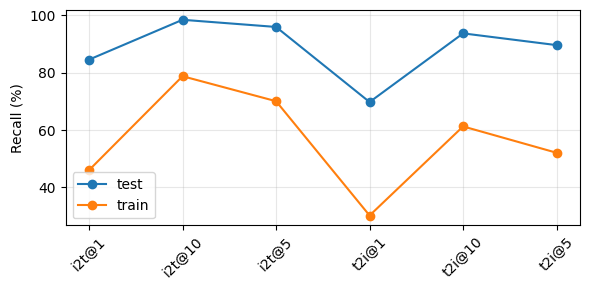

chunk baseline
metric      i2t@1     i2t@10      i2t@5      t2i@1     t2i@10      t2i@5
split                                                                   
test    83.100000  97.700000  95.200000  67.400000  93.120000  88.680000
train   40.912601  75.049525  65.920156  27.402209  58.323205  48.946715


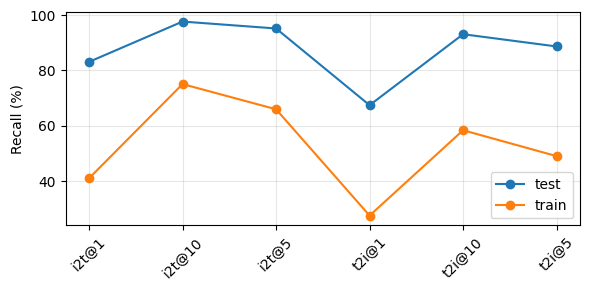

In [ ]:
for variant in baseline_df["variant"].unique():
    pivot = baseline_df[baseline_df["variant"] == variant].pivot(
        index="split",
        columns="metric",
        values="recall",
    )
    print(f"{variant} baseline\n{pivot}")
    fig, ax = plt.subplots(figsize=(6, 3))
    for split in pivot.index:
        ax.plot(pivot.columns, pivot.loc[split], marker="o", label=split)
    ax.set_ylabel("Recall (%)")
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
# Adapter training and evaluation across distillation weights
teacher_caps_full: Optional[torch.Tensor] = None
teacher_img2cap_full: Optional[List[List[int]]] = None
if any(w > 0 for w in DISTILL_WEIGHTS):
    teacher_source = chunk_baseline_embeddings if TEXT_CHUNK_WORDS > 0 else baseline_original_embeddings
    caps_tensor = torch.tensor(
        teacher_source["train"]["caption_embeddings"],
        dtype=torch.float32,
    )
    caps_tensor = normalize_features(caps_tensor)
    teacher_caps_full = caps_tensor.cpu() if TEACHER_CAPTION_CACHE_ON_CPU else caps_tensor.to(device)
    teacher_img2cap_full = cast(
        List[List[int]],
        teacher_source["train"]["image_to_caption_indices"],
    )




=== distill_weight=0.2 ===
step 000 loss=1.0775 scale=99.00
step 010 loss=0.5351 scale=99.00
step 020 loss=1.4669 scale=99.00
step 030 loss=0.7363 scale=99.00
step 040 loss=1.2269 scale=99.00
step 050 loss=1.2090 scale=99.00
step 060 loss=0.6618 scale=99.00
step 070 loss=0.4733 scale=99.00
step 080 loss=0.6956 scale=99.00
step 090 loss=0.7992 scale=99.00
step 100 loss=0.7486 scale=99.00
step 110 loss=0.4099 scale=98.99
step 120 loss=0.8230 scale=98.99
step 130 loss=0.9168 scale=98.99
step 140 loss=1.1224 scale=98.99
step 150 loss=0.9049 scale=98.99
step 160 loss=0.8235 scale=98.99
step 170 loss=0.8807 scale=98.99
step 180 loss=0.4798 scale=98.99
step 190 loss=0.8668 scale=98.99
step 200 loss=0.5629 scale=98.99
step 210 loss=0.6581 scale=98.99
step 220 loss=1.2277 scale=98.99
step 230 loss=0.9011 scale=98.99
step 240 loss=1.0050 scale=98.99
step 250 loss=1.1195 scale=98.99
step 260 loss=1.0495 scale=98.99
step 270 loss=0.4405 scale=98.99
step 280 loss=1.1178 scale=98.99
step 290 loss=0

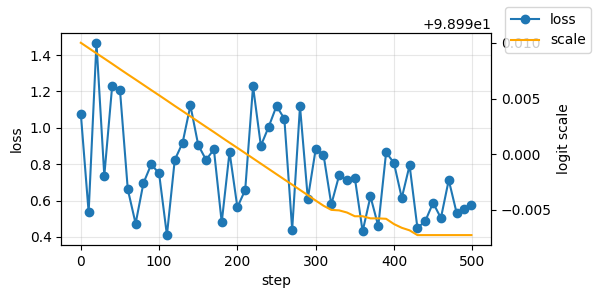

encoding train|adapter_0.2...
adapter (distill=0.2) train:
  t2i@1: 28.60
  t2i@5: 50.85
  t2i@10: 60.45
  i2t@1: 39.73
  i2t@5: 64.41
  i2t@10: 74.35
encoding test|adapter_0.2...
adapter (distill=0.2) test:
  t2i@1: 68.64
  t2i@5: 90.16
  t2i@10: 94.36
  i2t@1: 82.30
  i2t@5: 96.50
  i2t@10: 98.10

=== distill_weight=0.75 ===
step 000 loss=0.7882 scale=98.98
step 010 loss=0.9222 scale=98.98
step 020 loss=0.6969 scale=98.98
step 030 loss=1.2033 scale=98.98
step 040 loss=0.7887 scale=98.98
step 050 loss=0.8342 scale=98.98
step 060 loss=1.4090 scale=98.98
step 070 loss=0.8958 scale=98.98
step 080 loss=0.7944 scale=98.98
step 090 loss=1.1683 scale=98.98
step 100 loss=0.7891 scale=98.98
step 110 loss=0.8444 scale=98.98
step 120 loss=1.0002 scale=98.98
step 130 loss=0.6953 scale=98.98
step 140 loss=0.7474 scale=98.98
step 150 loss=1.1146 scale=98.98
step 160 loss=0.5946 scale=98.98
step 170 loss=0.7109 scale=98.97
step 180 loss=0.6166 scale=98.97
step 190 loss=0.3249 scale=98.97
step 200 lo

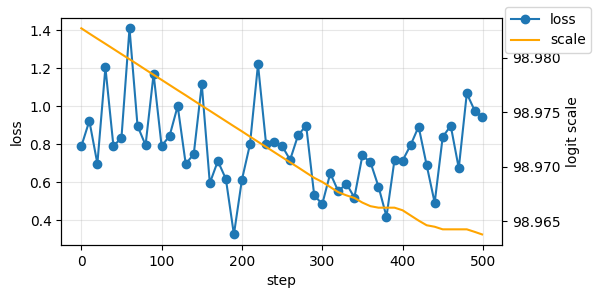

encoding train|adapter_0.75...
adapter (distill=0.75) train:
  t2i@1: 28.41
  t2i@5: 50.59
  t2i@10: 60.28
  i2t@1: 39.59
  i2t@5: 64.58
  i2t@10: 74.33
encoding test|adapter_0.75...
adapter (distill=0.75) test:
  t2i@1: 68.68
  t2i@5: 90.24
  t2i@10: 94.24
  i2t@1: 82.30
  i2t@5: 96.20
  i2t@10: 98.00


In [ ]:

results_summary: List[Dict[str, object]] = []

for distill_weight in DISTILL_WEIGHTS:
    print(f"\n=== distill_weight={distill_weight} ===")

    detach_text_adapters(model)
    adapter = attach_text_adapters(model, ADAPTER_HIDDEN)
    model.to(device)
    model.eval()

    for p in model.parameters():
        p.requires_grad_(False)
    for p in adapter.parameters():
        p.requires_grad_(True)

    logit_scale = cast(torch.nn.Parameter, model.logit_scale)
    logit_scale.requires_grad_(True)

    adapter_params = [p for p in adapter.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(
        [
            {"params": adapter_params, "lr": ADAPTER_LR, "weight_decay": 1e-4},
            {"params": [logit_scale], "lr": ADAPTER_LOGIT_LR, "weight_decay": 0.0},
        ]
    )

    teacher_caps = teacher_caps_full if distill_weight > 0 else None
    teacher_img2cap = teacher_img2cap_full if distill_weight > 0 else None

    train_indices = list(range(len(datasets["train"])))
    loss_log: List[Tuple[int, float, float]] = []

    for step in range(ADAPTER_STEPS):
        batch_idx = random.sample(train_indices, k=min(ADAPTER_BATCH, len(train_indices)))
        captions: List[str] = []
        images: List[torch.Tensor] = []
        caption_segments: List[str] = []
        caption_spans: List[Tuple[int, int]] = []
        segment_image_indices: List[int] = []
        teacher_pick: List[int] = []
        for idx in batch_idx:
            entry = datasets["train"][idx]
            caption_list = cast(List[str], entry["captions"])
            cap_pos = random.randrange(len(caption_list))
            selected_caption = caption_list[cap_pos]
            captions.append(selected_caption)
            image_path = Path(str(entry["image_path"]))
            with Image.open(image_path).convert("RGB") as img:
                images.append(image_transform(img))

            image_id = image_path.stem
            segments = build_semantic_segments(image_id, cap_pos, selected_caption, entity_caches["train"])
            start = len(caption_segments)
            caption_segments.extend(segments)
            caption_spans.append((start, len(caption_segments)))
            segment_image_indices.extend([len(images) - 1] * len(segments))

            if teacher_img2cap is not None:
                teacher_pick.append(teacher_img2cap[idx][cap_pos])

        image_tensor = torch.stack(images, dim=0).to(device)
        with torch.no_grad():
            encoded_images = model.encode_image(image_tensor).float()  # type: ignore[attr-defined]
        image_features = normalize_features(encoded_images)

        if not caption_segments:
            raise RuntimeError("No caption segments generated for training batch")

        segment_tokens = tokenizer(caption_segments).to(device)
        segment_embeds = model.encode_text(segment_tokens).float()  # type: ignore[attr-defined]
        segment_embeds = normalize_features(segment_embeds)
        pooled_text: List[torch.Tensor] = []
        for start, end in caption_spans:
            pooled_text.append(pool_chunk_embeddings(segment_embeds[start:end], mode=TEXT_POOLING))
        text_features = torch.stack(pooled_text, dim=0)

        logits = (text_features @ image_features.t()) * logit_scale.exp()
        targets = torch.arange(logits.size(0), device=device)
        loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.t(), targets)) * 0.5

        if FINE_GRAINED_WEIGHT > 0 and segment_image_indices:
            seg_targets = torch.tensor(segment_image_indices, dtype=torch.long, device=device)
            fine_logits = (segment_embeds @ image_features.t()) * logit_scale.exp()
            fine_loss = F.cross_entropy(fine_logits, seg_targets)
            loss = loss + FINE_GRAINED_WEIGHT * fine_loss

        if teacher_caps is not None and teacher_pick:
            teacher_device = teacher_caps.device
            idx_tensor = torch.tensor(teacher_pick, dtype=torch.long, device=teacher_device)
            teacher_batch = teacher_caps[idx_tensor].to(device)
            loss = loss + distill_weight * F.mse_loss(text_features, teacher_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(adapter_params + [logit_scale], max_norm=1.0)
        optimizer.step()
        logit_scale.data.clamp_(min=math.log(1 / 50), max=math.log(99))

        if step % 10 == 0 or step == ADAPTER_STEPS - 1:
            loss_log.append((step, float(loss.item()), float(logit_scale.exp().item())))
            print(f"step {step:03d} loss={loss.item():.4f} scale={logit_scale.exp().item():.2f}")

    if loss_log:
        steps, losses, scales = zip(*loss_log)
        fig, ax1 = plt.subplots(figsize=(6, 3))
        ax1.plot(steps, losses, marker="o", label="loss")
        ax1.set_ylabel("loss")
        ax2 = ax1.twinx()
        ax2.plot(steps, scales, color="orange", label="scale")
        ax2.set_ylabel("logit scale")
        ax1.set_xlabel("step")
        ax1.grid(alpha=0.3)
        fig.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    adapter_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}
    for split in RUN_SPLITS:
        if TEXT_CHUNK_WORDS > 0:
            image_cache = chunk_image_cache.get(split) if CACHE_CHUNK_IMAGE_EMBEDS else None
            emb = encode_chunked_embeddings(
                split,
                entity_caches[split],
                progress_desc=f"{split}|adapter_{distill_weight}",
                image_embed_cache=image_cache,
            )
            if CACHE_CHUNK_IMAGE_EMBEDS and image_cache is None:
                chunk_image_cache[split] = np.asarray(emb["image_embeddings"], dtype=np.float32)
        else:
            emb = run_clip_encoding(
                split,
                pooling="mean",
                chunk_words=0,
                chunk_stride=0,
            )
        metrics = compute_recalls(emb)
        adapter_metrics[split] = metrics
        print(f"adapter (distill={distill_weight}) {split}:")
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                print(f"  {tag}@{k}: {metrics[tag][k] * 100:.2f}")

    for tag in ("t2i", "i2t"):
        for k in K_VALUES:
            results_summary.append(
                {
                    "distill": distill_weight,
                    "metric": f"{tag}@{k}",
                    "adapter": adapter_metrics["test"][tag][k] * 100.0,
                    "baseline_original": baseline_original_metrics["test"][tag][k] * 100.0,
                    "baseline_chunk": chunk_baseline_metrics["test"][tag][k] * 100.0,
                }
            )

    detach_text_adapters(model)
    logit_scale.requires_grad_(False)


In [ ]:
summary_df = pd.DataFrame(results_summary)
print("\nSummary (test split):")
print(
    summary_df.pivot_table(
        index="metric",
        columns="distill",
        values="adapter",
    )
)


Summary (test split):
distill   0.20   0.75
metric               
i2t@1    82.30  82.30
i2t@10   98.10  98.00
i2t@5    96.50  96.20
t2i@1    68.64  68.68
t2i@10   94.36  94.24
t2i@5    90.16  90.24


In [ ]:
metrics_order = sorted(summary_df["metric"].unique())
variant_to_values: Dict[str, List[float]] = {}

In [ ]:
def extract_metric_values(metric_source: Dict[str, Dict[int, float]]) -> List[float]:
    values: List[float] = []
    for metric in metrics_order:
        tag, k_str = metric.split("@")
        values.append(metric_source[tag][int(k_str)] * 100.0)
    return values

In [ ]:
variant_to_values["baseline_original"] = extract_metric_values(baseline_original_metrics["test"])
variant_to_values["baseline_chunk"] = extract_metric_values(chunk_baseline_metrics["test"])


In [ ]:
for weight in DISTILL_WEIGHTS:
    adapter_rows = summary_df[summary_df["distill"] == weight]
    adapter_map = {row["metric"]: float(row["adapter"]) for _, row in adapter_rows.iterrows()}
    variant_to_values[f"adapter_{weight:.2f}"] = [adapter_map[m] for m in metrics_order]

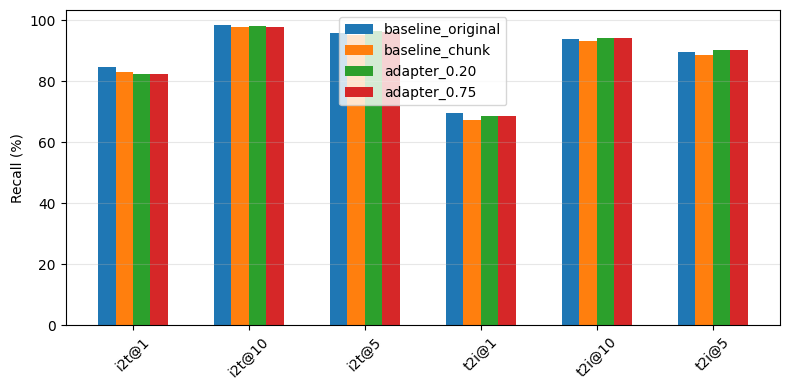

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(metrics_order))
total_variants = len(variant_to_values)
width = min(0.8 / total_variants, 0.15)


for idx, (label, values) in enumerate(variant_to_values.items()):
    offset = (idx - (total_variants - 1) / 2) * width
    ax.bar(x + offset, values, width, label=label)

ax.set_xticks(x)
ax.set_xticklabels(metrics_order, rotation=45)
ax.set_ylabel("Recall (%)")
ax.grid(alpha=0.3, axis="y")
ax.legend()
plt.tight_layout()
plt.show()